# Nearest Neighbor Image Classification of packs on shop shelf
In a nutshell:
1. Classify Product shots from 10 classes - 2744 in total ([dataset source](https://github.com/gulvarol/grocerydataset))
- [Part-1](https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part1.tar.gz)
- [Part-2](https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz)
2. Used **`50% (1374) for training, 50% (1370) for validating`**. Doesn't need many images for training.
3. Used predictor vector of [tensorflow_hub classifier](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) as **`1001-dimensional feature vector`** to represent each image
4. **`5-stage feature transformation`** on raw numbers to compute a **`novel similarity metric`** (Bonding Quotient) between images
5. The transformation involved computing dataset distribution specific 5-point scale and weights
6. **`Top-1 Validation accuracy: 99.6 (1364/1370 correct).`**
7. **`Top-5 Validation Accuracy: 99.9 (1368/1370 correct).`**
8. Error analysis indicate blurred images are hard to recognize as it gets mixed up with blurred images of other classes.
9. This also showed that there are instances of image labeling errors. Thorough checking needed of labeling

## Steps:

Ran the notebook in colab which was convenient.

1. Get tensorflow hub classifier
2. Define a few useful functions
3. Load data
4. Compute feature matrix of all images (raw data RD) and basic featrue transformation
5. Compute RD_train
6. Compute similarity matrix of training images - BQRS (Bonding Quotient Raw Score)
7. Nearest neighbor prediction for each of the 1370 validation images

### 1. Get tensorflow hub classifier

##### Copyright 2018 The TensorFlow Authors.

**Import tf_hub**

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf

     |████████████████████████████████| 533.1MB 24kB/s 
     |████████████████████████████████| 2.9MB 38.2MB/s 
     |████████████████████████████████| 2.8MB 40.0MB/s 
     |████████████████████████████████| 460kB 46.9MB/s 
     |████████████████████████████████| 778kB 37.2MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [2]:
!pip install -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 102kB 2.7MB/s 


**Get classifier**

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer. Any [TensorFlow 2 compatible image classifier URL](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

**Align image shape to imagenet input**

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### 2. Define a few useful functions

**Import necessary packages for classification**

In [0]:
import numpy as np
import pandas as pd
import PIL.Image as Image
import glob
import scipy.misc
import matplotlib
import cv2
import os
import sys
import multiprocessing
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from tqdm import tnrange, tqdm_notebook, notebook
from datetime import datetime, timedelta
import pytz
from skimage.io import imread_collection
from skimage import io
import imageio
import time, psutil
import pickle
from statistics import mode
import json
import random

Check time left with colab. Useful when working with larger datasets

In [0]:
def colabtime_left():
  Start = time.time()- psutil.boot_time()
  Left= 12*3600 - Start
  print('Time remaining for this session is: ', Left/3600)

In [10]:
colabtime_left()

Time remaining for this session is:  11.649252831670973


Check out RAM usage at this stage. If there are variables not needed henceforth, they can be deleted. We don't want out of memory errors. We are safe in this case as datasize is small.

In [0]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [13]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      Parallel:  1.0 KiB
                           _i5:  569.0 B
                      datetime:  400.0 B
                     timedelta:  400.0 B
                            _i:  371.0 B
                          _i12:  371.0 B
                           _i1:  290.0 B
                          _i13:  252.0 B
                           _oh:  240.0 B
                           Out:  240.0 B


**Set time zone**

Set it for India where I'm currently located.

In [0]:
tz_cal = pytz.timezone('Asia/Calcutta')

**Useful Function 1: `Image viewer`**

In [0]:
def image_viewer(image, truncate, truncate_down=True):
  """
  Input : image to view, truncate to chop off height from top - 1 means no chop
  Output: image view
  """
  if truncate == 0:
    grace_hopper=tf.keras.preprocessing.image.load_img(
        image,
        grayscale=False,
        color_mode='rgb',
        target_size=IMAGE_SHAPE,
        interpolation='nearest')
  else:
    if truncate_down:
      grace_hopper=tf.keras.preprocessing.image.load_img(
          image,
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest')
      grace_hopper = np.array(grace_hopper)
      grace_hopper = grace_hopper[:int(grace_hopper.shape[0]*truncate),:,:]
      matplotlib.image.imsave('name.png', grace_hopper)
      grace_hopper=tf.keras.preprocessing.image.load_img(
          'name.png',
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest')
    else:
      grace_hopper=tf.keras.preprocessing.image.load_img(
          image,
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest')
      grace_hopper = np.array(grace_hopper)
      grace_hopper = grace_hopper[int(grace_hopper.shape[0]*truncate):,:,:]
      matplotlib.image.imsave('name.png', grace_hopper)
      grace_hopper=tf.keras.preprocessing.image.load_img(
          'name.png',
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest')
  return grace_hopper

**Useful Function 2: `RD maker` given an image using transfer learned class label weights as features**

In [0]:
def RD_maker_transfer_learned(img, truncate, truncate_down=True):
  if truncate == 0:
    grace_hopper=tf.keras.preprocessing.image.load_img(
        img,
        grayscale=False,
        color_mode='rgb',
        target_size=IMAGE_SHAPE,
        interpolation='nearest'
        )
    grace_hopper = np.array(grace_hopper)
    grace_hopper = np.array(grace_hopper)/255.0
    result = classifier.predict(grace_hopper[np.newaxis, ...])

  else:
    if truncate_down:
      grace_hopper=tf.keras.preprocessing.image.load_img(
          img,
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest'
          )
      grace_hopper = np.array(grace_hopper)
      grace_hopper = grace_hopper[:int(grace_hopper.shape[0]*truncate),:,:]

      matplotlib.image.imsave('name.png', grace_hopper)
      grace_hopper=tf.keras.preprocessing.image.load_img(
          'name.png',
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest'
          )
      grace_hopper = np.array(grace_hopper)
      grace_hopper = np.array(grace_hopper)/255.0
      result = classifier.predict(grace_hopper[np.newaxis, ...])
    else:
      grace_hopper=tf.keras.preprocessing.image.load_img(
          img,
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest'
          )
      grace_hopper = np.array(grace_hopper)
      grace_hopper = grace_hopper[int(grace_hopper.shape[0]*truncate):,:,:]

      matplotlib.image.imsave('name.png', grace_hopper)
      grace_hopper=tf.keras.preprocessing.image.load_img(
          'name.png',
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest'
          )
      grace_hopper = np.array(grace_hopper)
      grace_hopper = np.array(grace_hopper)/255.0
      result = classifier.predict(grace_hopper[np.newaxis, ...])

  return result.reshape(-1,1)

**Useful Function 3: Viewing a group of images together**

In [0]:
def view_cluster_center(nrows, ncols, image_names, images, fontsize):
  if nrows>1:
    fig, ax = plt.subplots(nrows, ncols, figsize=(18,8))
    for i in range(nrows):
      for j in range(ncols):
        ax[i,j].imshow(io.imread(image_names[i*ncols+j]))
        ax[i,j].axis('off')
        ax[i,j].set_title(images[i*ncols+j], fontsize=fontsize)
  else:
    fig, ax = plt.subplots(ncols, figsize=(20,8))
    for i in range(ncols):
      ax[i].imshow(io.imread(image_names[i]))
      ax[i].axis('off')
      ax[i].set_title(images[i], fontsize=fontsize)
  plt.show()

## 3. Load unlabeled data
You can download the data by uncommenting following cells. I had data data in a google drive. Hence mounted the drive first

In [0]:
# !wget https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part1.tar.gz
# !wget https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz

In [0]:
# !tar -xvzf GroceryDataset_part1.tar.gz
# !tar -xvzf GroceryDataset_part2.tar.gz

In [0]:
# !bash -c 'mv /content/ProductImagesFromShelves /content/drive/My\ Drive/'

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**`Input Folder Pick up` for images from Drive**

In [19]:
folders = glob.glob('/content/drive/My Drive/ProductImagesFromShelves/*')
len(folders)

11

In [20]:
folders

['/content/drive/My Drive/ProductImagesFromShelves/3',
 '/content/drive/My Drive/ProductImagesFromShelves/4',
 '/content/drive/My Drive/ProductImagesFromShelves/6',
 '/content/drive/My Drive/ProductImagesFromShelves/1',
 '/content/drive/My Drive/ProductImagesFromShelves/10',
 '/content/drive/My Drive/ProductImagesFromShelves/8',
 '/content/drive/My Drive/ProductImagesFromShelves/2',
 '/content/drive/My Drive/ProductImagesFromShelves/9',
 '/content/drive/My Drive/ProductImagesFromShelves/5',
 '/content/drive/My Drive/ProductImagesFromShelves/7',
 '/content/drive/My Drive/ProductImagesFromShelves/0']

**Getting number of files across 11 folders**

In [22]:
import os, os.path
filecount=0
for folder in folders:
  filecount += len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))])
print('Total number of files across all folders: ', filecount) 

Total number of files across all folders:  13184


**Create raw data (RD) for this full dataset leading to 1001 features x 13184 packs matrix. Before that let's see how a pack looks**

In [24]:
packs = []
image_path = '/content/drive/My Drive/ProductImagesFromShelves/'
for i in range(len(folders)):
  folder_path = str(i)
  filenames = [f for f in os.listdir(f'{image_path}{folder_path}') if f.endswith('png')]
  packs.extend([image_path + folder_path + '/' + filenames[i] for i in range(len(filenames))])
print(' Total number of image files across folders: ', len(packs), '\n',
      'A sample file name:', packs[0])

 Total number of image files across folders:  13184 
 A sample file name: /content/drive/My Drive/ProductImagesFromShelves/0/C4_P05_N2_S4_1.JPG_2320_188_200_300.png


**Let's explore the data by viewing random image files out of 13184**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 13184 + 1) instead
  """Entry point for launching an IPython kernel.


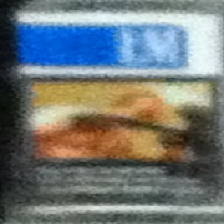

In [26]:
rndm_img_file = np.random.random_integers(0,len(packs),1)
image_viewer(packs[rndm_img_file[0]], truncate=0, truncate_down=False)

**Lower part of many packs changes keeping the branding part the same. Sometimes branding is at the lower part of the pack. So we cannot have one truncate logic for all packs. So we first truncate lower part of all packs and cluster and then come back truncate upper part and cluster again**

In [0]:
truncate = 0.4

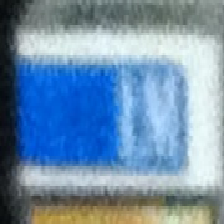

In [28]:
image_viewer(packs[rndm_img_file[0]], truncate=truncate, truncate_down=True)

## 4. Compute feature matrix of all images (raw data - RD)
This will give the distribution of the corpus in terms of 1001-dimensional vectors leading to suitable scaling and weights to apply for this corpus to compute the similarity measure, Bonding Quotient.

In [0]:
%%time
t0 = time.time()
RD = np.zeros((1001,len(packs)))       # Preallocate space for the large array
for i in range(len(packs)):
  RD[:,[i]] = RD_maker_transfer_learned(packs[i], truncate=truncate, truncate_down=True)
  if ((i%100 == 0) & (i>0)):
    t = time.time()
    so_far = t-t0
    avg = so_far/i
    exp = avg * (len(packs)-i)/60
    now = datetime.now(tz_cal)
    future = now + timedelta(minutes = exp)
    future_time = future.strftime("%H:%M:%S")
    print(f'Done {i} images in {so_far:.1f} s. Expect to finish at {future_time}.')

RD_max=RD.max()
RD = RD/RD_max

**Getting the class intervals for RD**

This is to convert raw numbers into a 5-point scale. The class intervals depend on the data distribution and is specific for this RD of the overall dataset.

In [0]:
class_int = [-0.079013246324737, -0.0311132463247423, 0.011086753675253, 0.065286753675247, 1.0000000000000000]  #  40%

**We found folder '0' contains mixed up packs as can be seen below. The rest of the folders named below.**

In [0]:
pack_name_dict = {0: 'Undefined',
                  1: 'Marlboro',
                  2: 'Kent',
                  3: 'Camel',
                  4: 'Parliament',
                  5: 'Pall Mall',
                  6: 'Monte Carlo',
                  7: 'Winston',
                  8: 'Lucky Strike',
                  9: '2001',
                  10: 'Lark'}

**Function to see contents of different folders**

In [0]:
def folder_viewer(i):
  """
  Input:  i is folder number from 0 to 10
  Output: view of 32 randomly chosen packs from the chosen folder
  """
  # image_path = '/content/ProductImagesFromShelves/'
  image_path = '/content/drive/My Drive/ProductImagesFromShelves/'
  folder_path = str(i)
  folder_files = [f for f in os.listdir(f'{image_path}{folder_path}') if f.endswith('png')]
  folder_path = str(i)
  shownum = 32;
  rndm_img_index_i = random.sample(range(len(folder_files)), shownum)
  rndm_img_files_i = [image_path + folder_path + '/' + folder_files[rndm_img_index_i[i]] for i in range(shownum)]
  rndm_img_names_i = [pack_name_dict[int(rndm_img_files_i[i].split('/')[-2])] for i in range(shownum)]
  view_cluster_center(4, 8, rndm_img_files_i, rndm_img_names_i, 10)

Let's see folder 0 to see the spread of different packs

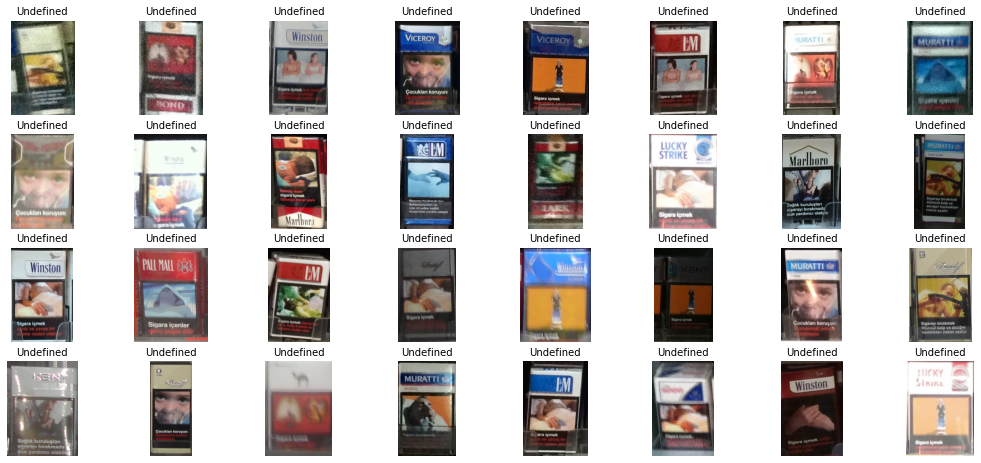

In [34]:
folder_viewer(0)

**Hence folder 0 removed from classification task. RD_train created from folders 1 to 10.**

### 5. Compute RD_train
We would select fixed % of images from each of the 10 folders to ensure balanced split between training and validation.

 First initialize variables. Using train:validation split of **0.5** to show how `it works with even small amount of training data`

In [0]:
trainImageClassIndex = []           # Class index of all N training images from across 120 class folders
train_ImageFileList = []            # List of image file names for training from across 120 class folders
val_ImageFileList = []              # List of image file names for validation from across 120 class folders
validation_split = 0.5
shuffle_dataset = True
random_seed= 42

**Now for RD_train**

a. First create list of files for training and validation


In [36]:
%%time
for i in range(1,len(folders)):
  imageFileNames = glob.glob('/content/drive/My Drive/ProductImagesFromShelves/' + str(i) + '/*.png')
  dataset_size = len(imageFileNames)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]
  train_ImageFileNames = [imageFileNames[i] for i in train_indices]       # List of image file names for training for each folder
  val_ImageFileNames = [imageFileNames[i] for i in val_indices]           # List of image file names for validation for each folder
  trainImageClassIndex.extend(np.ones(len(train_ImageFileNames))*(i))     # Training image class index
  train_ImageFileList.extend(train_ImageFileNames)                        # List of image files for use for training
  val_ImageFileList.extend(val_ImageFileNames)                            # List of image files for use for validation

CPU times: user 9.18 ms, sys: 4.9 ms, total: 14.1 ms
Wall time: 42.9 ms


In [37]:
len(trainImageClassIndex), len(train_ImageFileList), len(val_ImageFileList)

(1374, 1374, 1370)

b. Generate RD_train

In [38]:
%%time
t0 = time.time()
RD_train = np.zeros((1001,len(train_ImageFileList)))       # Pre-allocation for 1001 x N training data RD
for i in range(len(train_ImageFileList)):
  RD_train[:,[i]] = RD_maker_transfer_learned(train_ImageFileList[i], truncate=truncate,truncate_down=True)
  if ((i%100 == 0) & (i>0)):
    t = time.time()
    so_far = t-t0
    avg = so_far/i
    exp = avg * (len(train_ImageFileList)-i)/60
    now = datetime.now(tz_cal)
    future = now + timedelta(minutes = exp)
    future_time = future.strftime("%H:%M:%S")
    print(f'Done {i} images in {so_far:.1f} s. Expect to finish at {future_time}.')

Done 100 images in 42.9 s. Expect to finish at 14:08:13.
Done 200 images in 78.1 s. Expect to finish at 14:07:20.
Done 300 images in 115.4 s. Expect to finish at 14:07:12.
Done 400 images in 149.9 s. Expect to finish at 14:06:59.
Done 500 images in 185.4 s. Expect to finish at 14:06:53.
Done 600 images in 224.2 s. Expect to finish at 14:06:57.
Done 700 images in 261.5 s. Expect to finish at 14:06:57.
Done 800 images in 298.7 s. Expect to finish at 14:06:57.
Done 900 images in 337.2 s. Expect to finish at 14:06:59.
Done 1000 images in 372.9 s. Expect to finish at 14:06:56.
Done 1100 images in 408.8 s. Expect to finish at 14:06:55.
Done 1200 images in 444.9 s. Expect to finish at 14:06:53.
Done 1300 images in 478.7 s. Expect to finish at 14:06:50.
CPU times: user 2min 56s, sys: 6.06 s, total: 3min 2s
Wall time: 8min 29s


In [39]:
RD_train.shape, RD_train.max(), RD_train.min()

((1001, 1374), 12.437925338745117, -6.668549537658691)

In [44]:
print(' Shape of training raw data file: ', RD_train.shape, '\n',
      'Max value in RD_train: ', RD_train.max(), '\n',
      'Min value in RD_train: ', RD_train.min(), '\n',
      'Number of images set aside for validation: ', len(val_ImageFileList), '\n',
      'Number of images set aside for training: ', len(train_ImageFileList), '\n',
      'An example validation image file name: ', val_ImageFileList[15])

 Shape of training raw data file:  (1001, 1374) 
 Max value in RD_train:  12.437925338745117 
 Min value in RD_train:  -6.668549537658691 
 Number of images set aside for validation:  1370 
 Number of images set aside for training:  1374 
 An example validation image file name:  /content/drive/My Drive/ProductImagesFromShelves/1/C1_P04_N2_S4_1.JPG_840_832_208_332.png


**Normalize RD_train to make it comparable across datasets**

In [0]:
RD_train_max=RD_train.max()
RD_train_min=RD_train.min()
RD_train = RD_train/RD_train_max

**Convert raw numbers in RD_train to a 5-point scale using class intervals obtained earlier**

In [0]:
RD_train[RD_train < class_int[0]] = 1
RD_train[RD_train < class_int[1]] = 2
RD_train[RD_train < class_int[2]] = 3
RD_train[RD_train < class_int[3]] = 5
RD_train[RD_train < class_int[4]] = 7

### 6. Compute similarity matrix of training images - BQRS (Bonding Quotient Raw Score)
First the weights to be used given the distribution of the raw data

In [0]:
wt = [1.00,0.535252002086401,0.286494705737501,0.153346864833152,0.0820792164156171]  # 40%

**We will do a parallelized implementation of BQRS to make full use of colab TPU giving 40 workers. For that we will define BQRS function for input on 5-point scale**

In [0]:
def out_bqrs(RD_train, i, wt):
    
    a = np.multiply(RD_train[:,i].reshape([1001,-1]),RD_train[:,i:])
        
    a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
    a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
    a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
    a[a==5] = wt[3]; a[a==14] = wt[3]
    a[a==7] = wt[4]
    
    a = a.sum(axis=0)
    
    return a

In [0]:
num_cores = multiprocessing.cpu_count()

In [50]:
num_cores

2

In [51]:
%%time
results = Parallel(n_jobs=num_cores)(delayed(out_bqrs)(RD_train, i, wt) for i in notebook.tqdm(range(RD_train.shape[1])))


CPU times: user 3.17 s, sys: 241 ms, total: 3.41 s
Wall time: 33.8 s


In [52]:
%%time
BQRS = np.zeros((RD_train.shape[1], RD_train.shape[1]))
for i in range(RD_train.shape[1]):
    BQRS[(RD_train.shape[1] - len(results[i])),(RD_train.shape[1] - len(results[i])):] = results[i]
    BQRS[(RD_train.shape[1] - len(results[i])):,(RD_train.shape[1] - len(results[i]))] = results[i]

CPU times: user 17.6 ms, sys: 6.06 ms, total: 23.7 ms
Wall time: 28.6 ms


In [53]:
BQRS.shape

(1374, 1374)

**Check out RAM usage at this stage. If there are variables not needed henceforth, they can be deleted. We don't want out of memory errors. We are safe in this case as datasize is small.**

In [54]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          BQRS: 14.4 MiB
                      RD_train: 10.5 MiB
                         packs: 103.9 KiB
          trainImageClassIndex: 12.2 KiB
           train_ImageFileList: 12.2 KiB
             val_ImageFileList: 12.1 KiB
                       results: 11.9 KiB
                          _i16:  2.0 KiB
                      Parallel:  2.0 KiB
                          _i15:  1.6 KiB


### 7. Nearest neighbor prediction for each of the 1370 validation images

**Class Predictor Function**

Class Predictor Function Type C

In [0]:
def class_predictor(i, k, image_class_numeric=True):
  """
  Input:  index of image from `val_ImageFileList`
          top k neighbors to return
          whether image class is numeric like in this case or string
  Output: List of list of input image file, its class, top-k neighbors, number of correct predictions out of k, accuracy
  """
  output_list = []
  input_image = val_ImageFileList[i]
  input_image_class = input_image.split('/')[-2]
  test_feature = RD_maker_transfer_learned(input_image, truncate)
  test_feature = test_feature/RD_train_max

  test_feature[test_feature < class_int[0]] = 1
  test_feature[test_feature < class_int[1]] = 2
  test_feature[test_feature < class_int[2]] = 3
  test_feature[test_feature < class_int[3]] = 5
  test_feature[test_feature < class_int[4]] = 7
  RD_TEST = np.concatenate((RD_train, test_feature), axis=1)
  BQRS_test = np.zeros((RD_train.shape[1]+1, RD_train.shape[1]+1))
  a = np.multiply(RD_TEST[:,-1].reshape([1001,-1]),RD_TEST)
  a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
  a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
  a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
  a[a==5] = wt[3]; a[a==14] = wt[3]
  a[a==7] = wt[4]

  BQRS_test[-1,0:] = a.sum(axis=0)
  BQRS_test[0:,-1] = a.sum(axis=0)
  BQRS_test[:RD_train.shape[1],:RD_train.shape[1]] = BQRS
  BQRS_test = BQRS_test/np.diagonal(BQRS_test)
  BQRS_test = BQRS_test.T
  BQCorr1_test = np.zeros((RD_train.shape[1]+1))
  for j in range(RD_train.shape[1]+1):
    BQCorr1_test[j] = np.corrcoef(BQRS_test[-1], BQRS_test[j])[1,0]
    
  predicts_image_top_k = np.array(train_ImageFileList)[BQCorr1_test.argsort()[-(k+1):][::-1][1:]]
  predicts_class_top_k = np.array(trainImageClassIndex)[BQCorr1_test.argsort()[-(k+1):][::-1][1:]]
  if image_class_numeric :
    correct_class_prediction = ((predicts_class_top_k == int(input_image_class)) == True).sum()
  else:
    correct_class_prediction = ((predicts_class_top_k == input_image_class) == True).sum()
  
  if correct_class_prediction > (int(np.floor(k/2))-1):
    accuracy = 1
  else:
    accuracy = 0
    
  output_list.append([input_image, input_image_class, predicts_image_top_k, correct_class_prediction, accuracy])

  return output_list

# Input Validation Image number here

In [0]:
i=100  # 0 to 1369 since there are 1370 validation images

 Validation Image:  /content/drive/My Drive/ProductImagesFromShelves/1/C1_P04_N1_S5_2.JPG_156_1240_132_216.png 
 Class of Validation Image:  Marlboro 
 Class of Top 4 nearest neighbors:  Marlboro , Marlboro , Marlboro , Marlboro


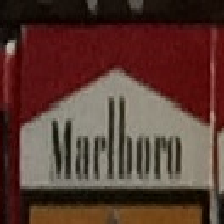

In [61]:
pred_output = class_predictor(i, 4, image_class_numeric=True)
top4_pred_list = [pred_output[0][2][i] for i in range(len(pred_output[0][2]))]
print(' Validation Image: ', pred_output[0][0], '\n',
      'Class of Validation Image: ', pack_name_dict[int(pred_output[0][1])], '\n',
      'Class of Top 4 nearest neighbors: ', pack_name_dict[int(pred_output[0][2][0].split('/')[-2])],',',\
      pack_name_dict[int(pred_output[0][2][1].split('/')[-2])],',' ,\
      pack_name_dict[int(pred_output[0][2][2].split('/')[-2])],',',\
      pack_name_dict[int(pred_output[0][2][3].split('/')[-2])])
image_viewer(pred_output[0][0], truncate)

Top 4 Nearest Neaighbors


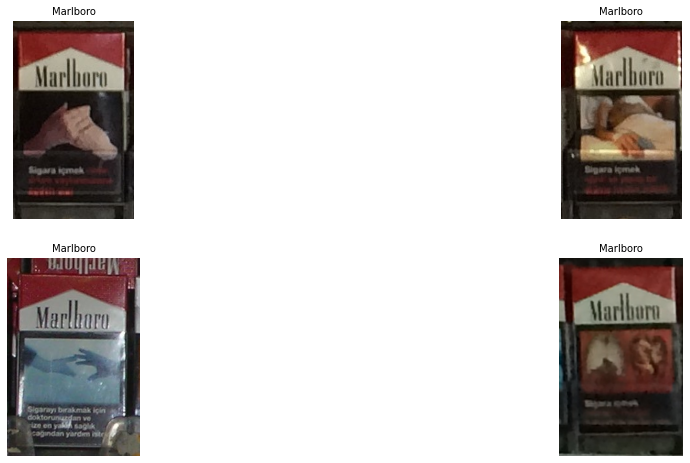

In [62]:
print('Top 4 Nearest Neaighbors')
top4_pred_name = [pack_name_dict[int(top4_pred_list[i].split('/')[-2])] for i in range(4)]
view_cluster_center(2, 2, top4_pred_list, top4_pred_name, 10)

**Overall Performance on Validation dataset based on top 1**

In [81]:
%%time
t0 = time.time()
top_k=1
output_list = []
cum_accuracy_class_level=0
cum_accuracy_image_level=0
for i in range(len(val_ImageFileList)):
  val_image_name = val_ImageFileList[i]                         # pick up val image no i out of some 2300
  # val_image_name = val_image_name.split('/')                   # Remove \\ from glob list
  # val_image_name_class = int(val_image_name.split('/')[-3])            # Note the class label of the val image
  val_image_name_class = val_image_name.split('/')[-2]                   # prodshelf Note the class label of the val image
  test_feature = RD_maker_transfer_learned(val_image_name, truncate)
  test_feature = test_feature/RD_train_max

  # prodshelf transfer learning
  test_feature[test_feature < class_int[0]] = 1
  test_feature[test_feature < class_int[1]] = 2
  test_feature[test_feature < class_int[2]] = 3
  test_feature[test_feature < class_int[3]] = 5
  test_feature[test_feature < class_int[4]] = 7

  RD_TEST = np.concatenate((RD_train, test_feature), axis=1)

  BQRS_test = np.zeros((RD_train.shape[1]+1, RD_train.shape[1]+1))
  a = np.multiply(RD_TEST[:,-1].reshape([1001,-1]),RD_TEST)

  a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
  a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
  a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
  a[a==5] = wt[3]; a[a==14] = wt[3]
  a[a==7] = wt[4]

  BQRS_test[-1,0:] = a.sum(axis=0)
  BQRS_test[0:,-1] = a.sum(axis=0)
  BQRS_test[:RD_train.shape[1],:RD_train.shape[1]] = BQRS
  BQRS_test = BQRS_test/np.diagonal(BQRS_test)                     # Bonding Quotient Normalized Score
  BQRS_test = BQRS_test.T
  BQCorr1_test = np.zeros((RD_train.shape[1]+1))
  for j in range(RD_train.shape[1]+1):
    BQCorr1_test[j] = np.corrcoef(BQRS_test[-1], BQRS_test[j])[1,0]

  predicts_image_top_k = np.array(train_ImageFileList)[BQCorr1_test.argsort()[-(top_k+1):][::-1][1:]]
  predicts_class_top_k = np.array(trainImageClassIndex)[BQCorr1_test.argsort()[-(top_k+1):][::-1][1:]]
  # correct_class_prediction = ((predicts_class_top_k == val_image_name_class) == True).sum()
  correct_class_prediction = ((predicts_class_top_k == int(val_image_name_class)) == True).sum()

  top20_image = np.array(train_ImageFileList)[BQCorr1_test.argsort()[-21:][::-1][1:]]
  top20_class = np.array(trainImageClassIndex)[BQCorr1_test.argsort()[-21:][::-1][1:]]

  if correct_class_prediction > (int(np.floor((top_k+1)/2))-1):
    accuracy = 1
  else:
    accuracy = 0
  cum_accuracy_class_level += accuracy
  cum_accuracy_image_level += correct_class_prediction

  output_list.append([i,val_image_name,val_image_name_class,predicts_image_top_k,correct_class_prediction,top20_image,top20_class,accuracy])
  print(i, val_image_name, val_image_name_class, correct_class_prediction, f'{cum_accuracy_class_level/(i+1):.3f}', 
        accuracy, f'{cum_accuracy_image_level/(top_k*(i+1)):.3f}')

t = time.time()
run_time = t-t0

0 /content/drive/My Drive/ProductImagesFromShelves/1/C2_P04_N1_S3_1.JPG_724_1100_152_232.png 1 1 1.000 1 1.000
1 /content/drive/My Drive/ProductImagesFromShelves/1/C1_P11_N1_S3_2.JPG_192_420_308_392.png 1 0 0.500 0 0.500
2 /content/drive/My Drive/ProductImagesFromShelves/1/C1_P05_N3_S3_1.JPG_2732_308_236_364.png 1 1 0.667 1 0.667
3 /content/drive/My Drive/ProductImagesFromShelves/1/C2_P09_N1_S7_2.JPG_732_84_112_168.png 1 1 0.750 1 0.750
4 /content/drive/My Drive/ProductImagesFromShelves/1/C1_P05_N1_S3_1.JPG_2512_1864_224_316.png 1 1 0.800 1 0.800
5 /content/drive/My Drive/ProductImagesFromShelves/1/C1_P01_N2_S3_1.JPG_1560_1068_312_496.png 1 1 0.833 1 0.833
6 /content/drive/My Drive/ProductImagesFromShelves/1/C1_P05_N3_S4_1.JPG_1668_108_220_336.png 1 1 0.857 1 0.857
7 /content/drive/My Drive/ProductImagesFromShelves/1/C1_P11_N1_S3_2.JPG_464_476_236_320.png 1 1 0.875 1 0.875
8 /content/drive/My Drive/ProductImagesFromShelves/1/C1_P11_N1_S4_2.JPG_548_348_232_308.png 1 1 0.889 1 0.889
9 /c

In [83]:
print(' i: ',output_list[0][0], '\n',
      'val_image_name: ', output_list[0][1], '\n',
      'val_image_name_class: ', output_list[0][2], '\n',
      'predicts_image_top_k: ', output_list[0][3], '\n',
      'correct_class_prediction: ', output_list[0][4], '\n',
      'top20_image: ', output_list[0][5], '\n',
      'top20_class: ', output_list[0][6], '\n',
      'accuracy: ', output_list[0][7])

 i:  0 
 val_image_name:  /content/drive/My Drive/ProductImagesFromShelves/1/C2_P04_N1_S3_1.JPG_724_1100_152_232.png 
 val_image_name_class:  1 
 predicts_image_top_k:  ['/content/drive/My Drive/ProductImagesFromShelves/1/C2_P04_N2_S4_1.JPG_836_644_160_260.png'] 
 correct_class_prediction:  1 
 top20_image:  ['/content/drive/My Drive/ProductImagesFromShelves/1/C2_P04_N2_S4_1.JPG_836_644_160_260.png'
 '/content/drive/My Drive/ProductImagesFromShelves/1/C2_P04_N3_S4_1.JPG_704_36_184_300.png'
 '/content/drive/My Drive/ProductImagesFromShelves/1/C2_P04_N2_S2_1.JPG_656_676_176_272.png'
 '/content/drive/My Drive/ProductImagesFromShelves/1/C2_P04_N3_S2_1.JPG_1036_220_172_272.png'
 '/content/drive/My Drive/ProductImagesFromShelves/1/C2_P04_N2_S3_1.JPG_668_656_184_260.png'
 '/content/drive/My Drive/ProductImagesFromShelves/1/C2_P04_N2_S3_1.JPG_820_644_184_260.png'
 '/content/drive/My Drive/ProductImagesFromShelves/1/C2_P04_N1_S4_1.JPG_948_1076_164_240.png'
 '/content/drive/My Drive/ProductImage

**Picking out Correct and Incorrect predictions from the ouput list**

In [0]:
incorrect = [output_list[i][1] for i in range(len(output_list)) if output_list[i][-1] == 0]
incorrect_top10_image = [output_list[i][-3] for i in range(len(output_list)) if output_list[i][-1] == 0]
incorrect_top10_class = [output_list[i][-2] for i in range(len(output_list)) if output_list[i][-1] == 0]
incorrect_preds = [[output_list[i][1],output_list[i][3]] for i in range(len(output_list)) if output_list[i][-1] == 0]

correct = [output_list[i][1] for i in range(len(output_list)) if output_list[i][-1] == 1]
correct_preds = [[output_list[i][1],output_list[i][3]] for i in range(len(output_list)) if output_list[i][-1] == 1]

In [86]:
print(' Prediction Accuracy at class level for pack Images: ', f'{sum([output_list[i][7] for i in range(len(output_list))])/len(output_list):.3f}', '\n',
      'Prediction Accuracy at image level for pack Images:', f'{sum([output_list[i][4] for i in range(len(output_list))])/(top_k*len(output_list)):.3f}', '\n',
      'Average time used to make 1 prediction: ', f'{run_time/len(val_ImageFileList):.2f}', 'seconds', '\n',
      'Number of correct predictions: ', len(correct), '\n',
      'Number of incorrect predictions: ', len(incorrect))

 Prediction Accuracy at class level for pack Images:  0.996 
 Prediction Accuracy at image level for pack Images: 0.996 
 Average time used to make 1 prediction:  0.39 seconds 
 Number of correct predictions:  1364 
 Number of incorrect predictions:  6


**Visualizing Error Analysis**

**For 1-nearest neighbor case**

In [0]:
i=0

 Validation Image:  /content/drive/My Drive/ProductImagesFromShelves/1/C1_P11_N1_S3_2.JPG_192_420_308_392.png 
 Class of Validation Image:  Marlboro 
 Class of the nearest neighbor:  Camel


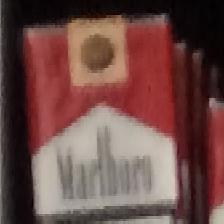

In [88]:
print(' Validation Image: ', incorrect_preds[i][0], '\n',
      'Class of Validation Image: ', pack_name_dict[int(incorrect_preds[i][0].split('/')[-2])], '\n',
      'Class of the nearest neighbor: ', pack_name_dict[int(incorrect_preds[i][1][0].split('/')[-2])])
image_viewer(incorrect[i], truncate=truncate,truncate_down=True)

### Top 20 nearest neighbors of Incorrectly Classified image

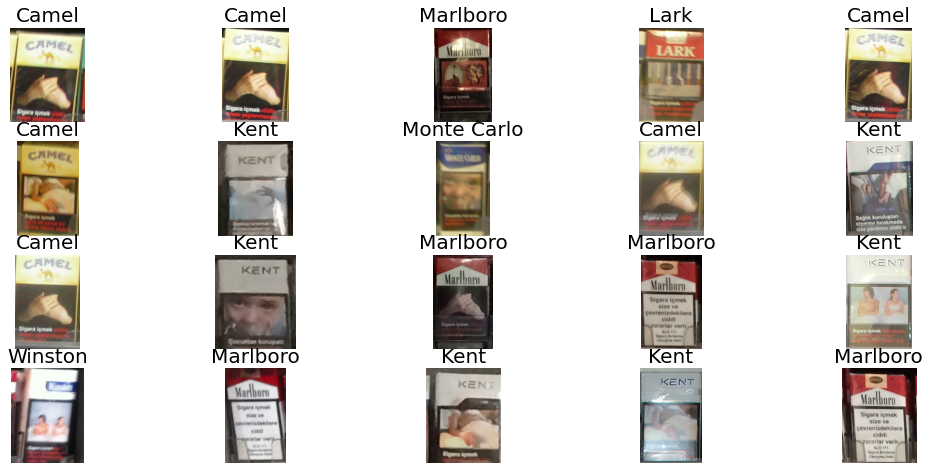

In [89]:
top10_incorrect_image = [incorrect_top10_image[i][j] for j in range(20)]
top10_incorrect_class = [pack_name_dict[int(incorrect_top10_class[i][j])] for j in range(20)]
view_cluster_center(4,5, top10_incorrect_image, top10_incorrect_class, fontsize=20)

# Plot accuracy at different levels of k

In [0]:
def accuracy_top_k(top_k):
  """
  Input:  top_k number to calculate accuracy at top_k level
  Output: Validation Accuracy at top_k
  """
  actual_class = [output_list[i][2] for i in range(len(output_list))]  # is string 'rose' etc for each val 
  top_20_pred_class = [output_list[i][6] for i in range(len(output_list))]   # list of 10 float like 1.0 etc for each val 
  corr=0
  hard_to_predict=[]
  bad_pred=[]
  for i in range(len(output_list)):
    if (np.array([str(int(top_20_pred_class[i][j])) == actual_class[i] for j in range(top_k)]) == True).sum() > 0:
      corr+=1
    else:
      num_corr_in_top_20=(np.array([str(int(top_20_pred_class[i][j])) == actual_class[i] for j in range(20)]) == True).sum()
      hard_to_predict.append([output_list[i][1],num_corr_in_top_20])
      bad_pred.append(output_list[i][5])
  accuracy=corr/len(output_list)
  num_errors=len(output_list)-corr
  print(f' Top-{top_k} Validation Accuracy is {accuracy:.3f}\
  i.e. number of incorrect cases are {len(output_list)-corr} out of {len(output_list)}')
  return accuracy,num_errors

In [140]:
acc_level=[accuracy_top_k(i) for i in range(1,21)]

 Top-1 Validation Accuracy is 0.996  i.e. number of incorrect cases are 6 out of 1370
 Top-2 Validation Accuracy is 0.998  i.e. number of incorrect cases are 3 out of 1370
 Top-3 Validation Accuracy is 0.999  i.e. number of incorrect cases are 2 out of 1370
 Top-4 Validation Accuracy is 0.999  i.e. number of incorrect cases are 2 out of 1370
 Top-5 Validation Accuracy is 0.999  i.e. number of incorrect cases are 2 out of 1370
 Top-6 Validation Accuracy is 0.999  i.e. number of incorrect cases are 2 out of 1370
 Top-7 Validation Accuracy is 0.999  i.e. number of incorrect cases are 2 out of 1370
 Top-8 Validation Accuracy is 0.999  i.e. number of incorrect cases are 2 out of 1370
 Top-9 Validation Accuracy is 0.999  i.e. number of incorrect cases are 2 out of 1370
 Top-10 Validation Accuracy is 0.999  i.e. number of incorrect cases are 1 out of 1370
 Top-11 Validation Accuracy is 0.999  i.e. number of incorrect cases are 1 out of 1370
 Top-12 Validation Accuracy is 0.999  i.e. number of

**Preparation of Plot data**

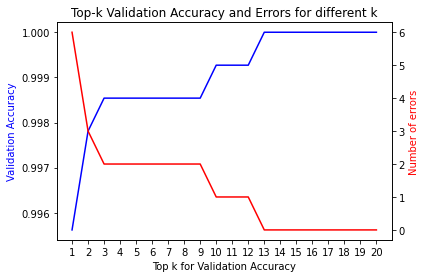

 Top-1 Validation Accuracy:  0.996 and 6 errors 
 Top-5 Validation Accuracy:  0.999 and 2 errors 
 Top-10 Validation Accuracy: 0.999 and 1 errors


In [141]:
k_range=list(range(1,21))
accuracy=[acc_level[i][0] for i in range(20)]
num_error=[acc_level[i][1] for i in range(20)]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(k_range, accuracy, 'b-')
ax2.plot(k_range, num_error, 'r-')

ax1.set_xlabel('Top k for Validation Accuracy')
plt.xticks(k_range)
ax1.set_ylabel('Validation Accuracy', color='b')
ax2.set_ylabel('Number of errors', color='r')
plt.title('Top-k Validation Accuracy and Errors for different k')
plt.show()
print(f' Top-1 Validation Accuracy:  {accuracy[0]:.3f} and {num_error[0]} errors \n\
 Top-5 Validation Accuracy:  {accuracy[4]:.3f} and {num_error[4]} errors \n\
 Top-10 Validation Accuracy: {accuracy[9]:.3f} and {num_error[9]} errors')

# Top-1, Top-5, and Top-10 accuracy with visualization
Study properties of bad predictions and hard to predict images

In [0]:
top_k=4

In [168]:
actual_class = [output_list[i][2] for i in range(len(output_list))]  # is string 'rose' etc for each val 
top_20_pred_class = [output_list[i][6] for i in range(len(output_list))]   # list of 10 float like 1.0 etc for each val 
corr=0
hard_to_predict=[]
bad_pred=[]
for i in range(len(output_list)):
  if (np.array([str(int(top_20_pred_class[i][j])) == actual_class[i] for j in range(top_k)]) == True).sum() > 0:
    corr+=1
  else:
    num_corr_in_top_20=(np.array([str(int(top_20_pred_class[i][j])) == actual_class[i] for j in range(20)]) == True).sum()
    hard_to_predict.append([output_list[i][1],num_corr_in_top_20])
    bad_pred.append(output_list[i][5])

accuracy=corr/len(output_list)
print(f' Top-{top_k} Validation Accuracy is {accuracy:.3f}\
 i.e. number of incorrect cases are {len(output_list)-corr} out of {len(output_list)}')

 Top-4 Validation Accuracy is 0.999 i.e. number of incorrect cases are 2 out of 1370


**Deep dive into each error image at a time**

In [0]:
i=1

**View the error pack**

 Validation image with label 2001


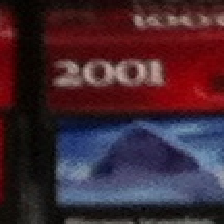

In [176]:
p=pack_name_dict[int(hard_to_predict[i][0].split('/')[-2])]
print(f' Validation image with label {p}')
image_viewer(hard_to_predict[i][0], truncate=0,truncate_down=False)

 Correct label 2001 was found at nearest neighbor index 10 and there are 4 correct out of top 20


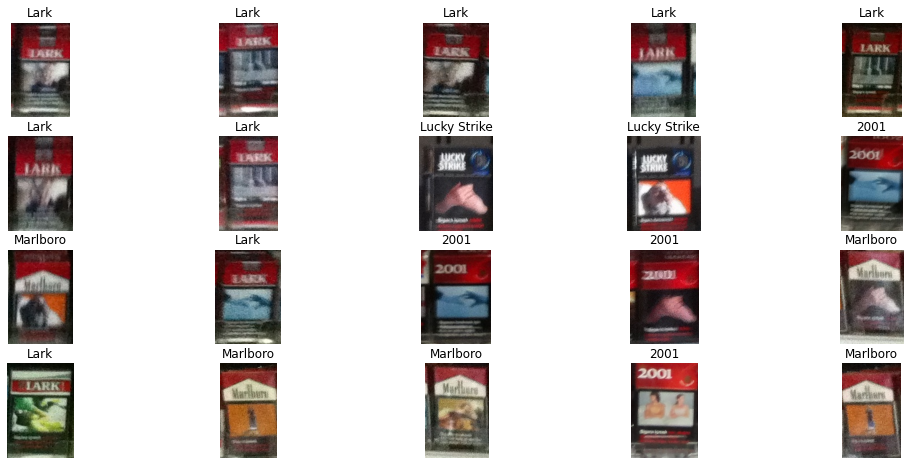

In [177]:
bad_prediction = bad_pred[i]
bad_class = [pack_name_dict[int(bad_prediction[j].split('/')[-2])] for j in range(20)]
num_corr = hard_to_predict[i][1]
try:
  q=bad_class.index(pack_name_dict[int(hard_to_predict[i][0].split('/')[-2])])
  print(f' Correct label {p} was found at nearest neighbor index {q+1} and there are {num_corr} correct out of top 20')
except ValueError:
  print(f' Correct label {p} was not found among top 10 and there are {num_corr} correct out of top 20')
view_cluster_center(4,5, bad_prediction, bad_class, fontsize=12)

**Look at the hard to predict validation Images**

In [178]:
pack_name_dict[int(hard_to_predict[i][0].split('/')[-2])]

'2001'

These are some of the images whose label was not in top 4 predictions


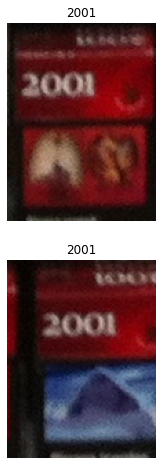

In [179]:
error_image = [hard_to_predict[i][0] for i in range(len(hard_to_predict))]
error_class = [pack_name_dict[int(hard_to_predict[i][0].split('/')[-2])] for i in range(len(hard_to_predict))]
print(f'These are some of the images whose label was not in top {top_k} predictions')
view_cluster_center(1,2, error_image, error_class, fontsize=12)

## 2 conclusions can be from the above error analysis:
1. Hazy images are hard to recognize
2. There are instances of labeling errors of packs. Theoretically it can cut both ways - making correct prediction wrong and wrong prediction correct.

Thorough checking of the labelling needed to remove them from the dataset.